<a href="https://colab.research.google.com/github/Sandesh816/Fine-tuned-Bias-Detection-and-Counter-Argument-Generation-model/blob/main/Model_training_and_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Phase 1: Bias Detection and Rationales Extraction**

**1.a Bias Detection**

In [ ]:
import requests
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import huggingface_hub
from transformers import AutoTokenizer, TFBertModel, AutoModelForCausalLM
from sklearn.model_selection import train_test_split
import keras_hub
from tensorflow import keras
from keras.regularizers import l2
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize
from sklearn.utils.multiclass import unique_labels

In [ ]:
RANDOM_STATE = 42

Load Data

In [ ]:
filename = "allsides_balanced_news_headlines-texts.csv"
url = 'https://raw.githubusercontent.com/irgroup/Qbias/refs/heads/main/allsides_balanced_news_headlines-texts.csv'
res = requests.get(url, allow_redirects=True)

with open(filename,'wb') as file:
    file.write(res.content)

df = pd.read_csv(filename)
print("Shape:", df.shape)
print(df.head(5))
print(f"Columns: {df.columns}")

Shape: (21754, 7)
   Unnamed: 0                                              title  \
0           0           Gun Violence Over Fourth of July Weekend   
1           1           Gun Violence Over Fourth of July Weekend   
2           2           Gun Violence Over Fourth of July Weekend   
3           3  Yellen Warns Congress of 'Economic Recession' ...   
4           4  Yellen Warns Congress of 'Economic Recession' ...   

                                                tags  \
0  ['Protests', 'Fourth Of July', 'Gun Control An...   
1  ['Protests', 'Fourth Of July', 'Gun Control An...   
2  ['Protests', 'Fourth Of July', 'Gun Control An...   
3  ['Janet Yellen', 'Debt Ceiling', 'Economic Pol...   
4  ['Janet Yellen', 'Debt Ceiling', 'Economic Pol...   

                                             heading                 source  \
0  Chicago Gun Violence Spikes and Increasingly F...  New York Times (News)   
1  ‘Bullets just came from nowhere’: Fourth of Ju...        Chicago Tribune   

In [ ]:
# Drop 'Unnamed: 0' column and reset index
df.drop(columns= ["Unnamed: 0"], inplace = True)
df.reset_index(drop = True, inplace = True)
print(df.columns)

Index(['title', 'tags', 'heading', 'source', 'text', 'bias_rating'], dtype='object')


Data Exploration

In [ ]:
model_name = "bert_medium_en_uncased" # other options include: 'bert-base-en-uncased' (larger), 'bert-small-en-uncased'
tokenizer_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# Explore number of labeled articles in each bucket
left_df = df[df["bias_rating"] == "left"]
right_df = df[df["bias_rating"] == "right"]
center_df = df[df["bias_rating"] == "center"]

print(f"Left: {left_df.shape}")
print(f"Right: {right_df.shape}")
print(f"Center: {center_df.shape}")

Left: (10275, 6)
Right: (7226, 6)
Center: (4253, 6)


In [ ]:
# Explore word counts across articles
left_word_count = sum(left_df["text"].fillna("").str.split().apply(len))
right_word_count = sum(right_df["text"].fillna("").str.split().apply(len))
center_word_count = sum(center_df["text"].fillna("").str.split().apply(len))

print("Left Leaning Articles Word Count:", left_word_count)
print("Right Leaning Articles Word Count:", right_word_count)
print("Center Leaning Articles Word Count:", center_word_count)

Left Leaning Articles Word Count: 658761
Right Leaning Articles Word Count: 481681
Center Leaning Articles Word Count: 301266


There is a discrepancy in the total word count of the articles labeled left, right, and center

In [ ]:
# Analyze the token count across the articles after tokenizing all text for some extra data exploration
left_token_count = sum(len(tokenizer.tokenize(str(text))) for text in left_df["text"] if pd.notna(text))
right_token_count = sum(len(tokenizer.tokenize(str(text))) for text in right_df["text"] if pd.notna(text))
center_token_count = sum(len(tokenizer.tokenize(str(text))) for text in center_df["text"] if pd.notna(text))

print("Left-leaning articles token count:", left_token_count)
print("Right-leaning articles token count:", right_token_count)
print("Center-leaning articles token count:", center_token_count)

Left-leaning articles token count: 837527
Right-leaning articles token count: 620797
Center-leaning articles token count: 388367


This discrepancy is mirrored in our token count

In [ ]:
# Analyze the average lengths of left, right, and center leaning articles to check quality of dataset
average_length_left = left_word_count / left_df.shape[0]
average_length_right = right_word_count / right_df.shape[0]
average_length_center = center_word_count / center_df.shape[0]

print("Average length of left-leaning articles:", average_length_left)
print("Average length of right-leaning articles:", average_length_right)
print("Average length of center-leaning articles:", average_length_center)

Average length of left-leaning articles: 64.11299270072993
Average length of right-leaning articles: 66.65942430113479
Average length of center-leaning articles: 70.83611568304725


Average article lengths for left, right, and center leaning articles are almost the same

In [ ]:
# Explore tag lengths across articles
left_tags_count = sum(left_df["tags"].fillna("").str.split(",").apply(len))
right_tags_count = sum(right_df["tags"].fillna("").str.split(",").apply(len))
center_tags_count = sum(center_df["tags"].fillna("").str.split(",").apply(len))

print("Left Leaning Articles Tags Count:", left_tags_count)
print("Right Leaning Articles Tags Count:", right_tags_count)
print("Center Leaning Articles Tags Count:", center_tags_count)

Left Leaning Articles Tags Count: 35898
Right Leaning Articles Tags Count: 27676
Center Leaning Articles Tags Count: 19801


Tag lengths are also reasonably closer

Data Preparation

In [ ]:
# Convert words to lowercase in all columns
df = df.map(lambda x: x.lower() if isinstance(x, str) else x)
print(df.head())

                                               title  \
0           gun violence over fourth of july weekend   
1           gun violence over fourth of july weekend   
2           gun violence over fourth of july weekend   
3  yellen warns congress of 'economic recession' ...   
4  yellen warns congress of 'economic recession' ...   

                                                tags  \
0  ['protests', 'fourth of july', 'gun control an...   
1  ['protests', 'fourth of july', 'gun control an...   
2  ['protests', 'fourth of july', 'gun control an...   
3  ['janet yellen', 'debt ceiling', 'economic pol...   
4  ['janet yellen', 'debt ceiling', 'economic pol...   

                                             heading                 source  \
0  chicago gun violence spikes and increasingly f...  new york times (news)   
1  ‘bullets just came from nowhere’: fourth of ju...        chicago tribune   
2  dozens of shootings across us mark bloody july...   new york post (news)   
3  federal

In [ ]:
# Train and testing sets
X = df[['title', 'heading', 'text','source','tags']]
y = df["bias_rating"]
print(X.head())
print(y.head())

                                               title  \
0           gun violence over fourth of july weekend   
1           gun violence over fourth of july weekend   
2           gun violence over fourth of july weekend   
3  yellen warns congress of 'economic recession' ...   
4  yellen warns congress of 'economic recession' ...   

                                             heading  \
0  chicago gun violence spikes and increasingly f...   
1  ‘bullets just came from nowhere’: fourth of ju...   
2  dozens of shootings across us mark bloody july...   
3  federal government will run out of cash on oct...   
4  yellen tells congress that u.s. will run out o...   

                                                text                 source  \
0  as yasmin miller drove home from a laundromat ...  new york times (news)   
1  as many chicagoans were celebrating the fourth...        chicago tribune   
2  the nation’s 4th of july weekend was marred by...   new york post (news)   
3  treasur

In [ ]:
label_mapping = {'left': 0, 'center': 1, 'right': 2}

y_mapped = y.map(label_mapping)

# Combine title, heading, source, tags, text columns for training
X_text = np.array((X["title"].fillna("") + ". " + X["heading"].fillna("") + ". " + X["source"].fillna("") + ". " + X["tags"].fillna("") + ". " + X["text"].fillna("")).to_list())

print(X_text[:5])

["gun violence over fourth of july weekend. chicago gun violence spikes and increasingly finds the youngest victims. new york times (news). ['protests', 'fourth of july', 'gun control and gun rights', 'chicago', 'violence in america']. as yasmin miller drove home from a laundromat in chicago’s englewood neighborhood last weekend, a gunman in another car peppered her red hyundai sedan with bullets, grazing her head and striking her son, sincere gaston, in the chest. sincere died in his car seat. he was 20 months old.\non june 20, a man fired gunshots through the back of a dark blue suv, wounding the 27-year-old man driving and hitting his stepson, mekhi james, in the back, killing him. mekhi was three.\ntwo girls, both aged three, were hospitalized..."
 "gun violence over fourth of july weekend. ‘bullets just came from nowhere’: fourth of july weekend gun violence kills at least 17, including 7-year-old-girl. chicago tribune. ['protests', 'fourth of july', 'gun control and gun rights', 

In [ ]:
# Split into training, testing with even ratio between articles from each side (stratify)
X_train, X_tmp, y_train, y_tmp = train_test_split(X_text, y_mapped, test_size=0.3, stratify=y_mapped, random_state=RANDOM_STATE, shuffle= True)
X_test, X_valid, y_test, y_valid = train_test_split(X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=RANDOM_STATE, shuffle= True)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}\n")

print("X_train data sample: \n", X_train[:5])
print("y_train data sample \n", y_train[:5])

X_train shape: (15227,)
y_train shape: (15227,)
X_test shape: (3263,)
y_test shape: (3263,)
X_valid shape: (3264,)
y_valid shape: (3264,)

X_train data sample: 
 ["perspectives: the doj's dismissal of michael flynn's case. if michael flynn did nothing wrong, why didn’t he tell the truth?. david ignatius. ['michael flynn', 'criminal justice', 'justice department', 'justice', 'russia', 'russia investigation', 'white house', 'fbi', 'defense and security']. with the justice department’s move thursday to drop its case against former national security adviser michael flynn, it’s useful to go back to a basic question: if flynn did nothing wrong when he called the russian ambassador on dec. 29, 2016, the day president barack obama imposed sanctions on russia for interfering in the presidential election, why did he conceal it?\none issue from the beginning was whether flynn’s call to ambassador sergey kislyak violated the logan act, which bars private u.s. citizens from trying to influence anot

In [ ]:
# To train our model, we need to tokenize our data
def tokenize_all(numpy_object):
  tokenized_texts = []
  for text in numpy_object.tolist():
    tokenized = tokenizer(text, padding=True, truncation=True, return_tensors="np")
    tokenized_texts.append(tokenized.input_ids[0])

  max_length = 250
  padded_sequences = pad_sequences(tokenized_texts, maxlen=max_length, padding='post', truncating='post')
  return padded_sequences

X_train_tokenized = tokenize_all(X_train)
X_test_tokenized = tokenize_all(X_test)
X_valid_tokenized = tokenize_all(X_valid)

print(f"X_train shape: {X_train_tokenized.shape}")
print(f"X_test shape: {X_test_tokenized.shape}")
print(f"X_valid shape: {X_valid_tokenized.shape}\n")

print(X_train_tokenized[:5])
print(X_test_tokenized[:5])
print(X_valid_tokenized[:5])

X_train shape: (15227, 250)
X_test shape: (3263, 250)
X_valid shape: (3264, 250)

[[  101 15251  1024 ...     0     0     0]
 [  101  2343  8398 ...     0     0     0]
 [  101  8398  6985 ...     0     0     0]
 [  101  4455  2005 ...     0     0     0]
 [  101  5924 19164 ...     0     0     0]]
[[  101 17688  2099 ...     0     0     0]
 [  101  2280  8398 ...     0     0     0]
 [  101 11417 15493 ...     0     0     0]
 [  101  2054  2000 ...     0     0     0]
 [  101 15251  1024 ...     0     0     0]]
[[  101 15941 12055 ...     0     0     0]
 [  101 23944 24641 ...     0     0     0]
 [  101  2715  2050 ...     0     0     0]
 [  101  2047 23702 ...     0     0     0]
 [  101 15251  1024 ...     0     0     0]]


Custom LSTM? (to compare against tf-idf baseline)

In [ ]:
# Create the train and validation dataset
BATCH = 32
train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train_tokenized, y_train))
      .shuffle(10_000)
      .batch(BATCH)
      .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    tf.data.Dataset.from_tensor_slices((X_valid_tokenized, y_valid))
      .batch(BATCH)
      .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
vocab_size = tokenizer.vocab_size
num_classes = 3

# Build our bidirectional LSTM model (embedding -> dropout -> biD -> dropout -> Dense -> Dense)
LSTM_model = Sequential()
LSTM_model.add(Embedding(input_dim=vocab_size, output_dim=128))
LSTM_model.add(tf.keras.layers.Dropout(0.5))
LSTM_model.add(tf.keras.layers.Bidirectional(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.001))))
LSTM_model.add(tf.keras.layers.Dropout(0.5))
LSTM_model.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
LSTM_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

LSTM_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
es = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# Train
history = LSTM_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[es],
    verbose="auto",
)

Epoch 1/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.5474 - loss: 1.0586 - val_accuracy: 0.8183 - val_loss: 0.5814
Epoch 2/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.7342 - loss: 0.6875 - val_accuracy: 0.9292 - val_loss: 0.3178
Epoch 3/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9455 - loss: 0.2799 - val_accuracy: 0.9436 - val_loss: 0.2524
Epoch 4/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9635 - loss: 0.2037 - val_accuracy: 0.9458 - val_loss: 0.2400
Epoch 5/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9668 - loss: 0.1789 - val_accuracy: 0.9547 - val_loss: 0.2601
Epoch 6/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9687 - loss: 0.1651 - val_accuracy: 0.9559 - val_loss: 0.2278
Epoch 7/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9742 - loss: 0.1386 - val_accuracy: 0.9574 - val_loss: 0.2188
Epoch 8/20
476/476 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9763 - loss: 0.1290 - 

Term Frequency with Logistic Regression Model

In [ ]:
# Create a pipeline with tf-idf and Logistic Regression
tf_idf_model = make_pipeline(
    TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english'),
    LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=RANDOM_STATE)
)

# Fit model
tf_idf_model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, multi_class='multinomial',
                                    random_state=42))])

In [ ]:
# Check accuracy for improvement
y_pred = tf_idf_model.predict(X_test)
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")


Accuracy: 0.9117


BERT Model

Now, we will finetune the pretrained BERT model for our text classification problem

We will use the process described by Keras to train on a portion of our data: https://keras.io/keras_hub/api/models/bert/bert_text_classifier/

In [ ]:
import keras_hub
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [ ]:
features = X_train.copy()
labels = y_train.copy()

# Pretrained classifier
BERT_model = keras_hub.models.BertTextClassifier.from_preset(
    model_name, # bert_medium_en_uncased
    num_classes=3,
)
BERT_model.fit(x=features, y=labels, batch_size=32)
BERT_model.predict(x=features, batch_size=32)

# Re-compile (e.g., with a new learning rate)
BERT_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), # SparseCategoricalCrossentropy
    optimizer="adam",
    jit_compile=True,
)
# Access backbone programmatically (e.g., to change `trainable`).
BERT_model.backbone.trainable = False
# Fit again.
num_epochs = 2
for _ in range(num_epochs):
  BERT_model.fit(x=features, y=labels, batch_size=32)

100%|██████████| 455/455 [00:00<00:00, 1.30MB/s]


100%|██████████| 158M/158M [00:05<00:00, 31.4MB/s]


476/476 ━━━━━━━━━━━━━━━━━━━━ 147s 175ms/step - loss: 0.4068 - sparse_categorical_accuracy: 0.8130
476/476 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step
476/476 ━━━━━━━━━━━━━━━━━━━━ 50s 58ms/step - loss: 0.0211 - sparse_categorical_accuracy: 0.9930
476/476 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - loss: 0.0218 - sparse_categorical_accuracy: 0.9926


Evaluating All Models

In [ ]:
def evaluate_model(model, X_test_original, X_test_processed, y_test, model_name):
  # class_names = ["Right", "Center", "Left"]

  # Predict probabilities
  if model_name == "Custom LSTM":
    y_prob = LSTM_model.predict(X_test_processed, batch_size=32)
  elif model_name == "BERT":
    y_prob = model.predict(X_test_original)
    y_prob = tf.nn.softmax(y_prob).numpy()
  else:
    y_prob = model.predict_proba(X_test_original)

  y_pred = np.argmax(y_prob, axis=1)

  class_names = [str(c) for c in np.unique(y_test)]

  # Classification Report
  print(f"\n----------Classification Report for {model_name}----------")
  print(classification_report(y_test, y_pred, target_names=class_names))
  print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")

  print("\n")
  # Confusion Matrix
  cm = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(6, 5))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
  plt.title(f'Confusion Matrix: {model_name}')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

  print("\n")
  # ROC Curve (for multiclass)
  y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))
  plt.figure(figsize=(8, 6))
  for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], 'k')
  plt.title(f'Multiclass ROC Curve: {model_name}')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.show()

  print("\n")
  # Softmax (Uncertainty) Distribution
  max_probs = np.max(y_prob, axis=1)
  plt.figure(figsize=(6, 4))
  sns.histplot(max_probs, bins=20, kde=True)
  plt.title(f'Softmax Max Probability Confidence: {model_name}')
  plt.xlabel('Max Softmax Probability')
  plt.ylabel('Count')
  plt.show()

  # Assess Good and Bad Predictions
  correct = np.where(y_pred == y_test)[0]
  incorrect = np.where(y_pred != y_test)[0]

  print(f"\n5 Good Predictions: ")
  for i in correct[:5]:
      print(f"True: {class_names[y_test.iloc[i]]}, Predicted: {class_names[y_pred[i]]}, Confidence: {max_probs[i]:.2f}, \nText: {X_test_original[i]}\n\n") # Use X_test_original

  print(f"\n5 Bad Predictions:")
  for i in incorrect[:5]:
      print(f"True: {class_names[y_test.iloc[i]]}, Predicted: {class_names[y_pred[i]]}, Confidence: {max_probs[i]:.2f},\nText: {X_test_original[i]}\n\n") # Use X_test_original

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

----------Classification Report for Custom LSTM----------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1541
           1       0.99      0.97      0.98       638
           2       0.98      0.99      0.98      1084

    accuracy                           0.99      3263
   macro avg       0.99      0.98      0.98      3263
weighted avg       0.99      0.99      0.99      3263


Accuracy: 0.9859




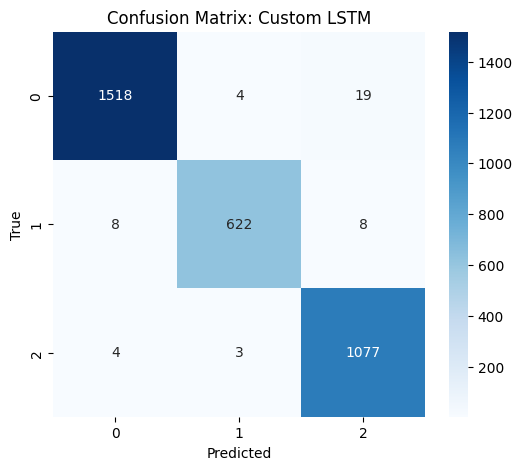

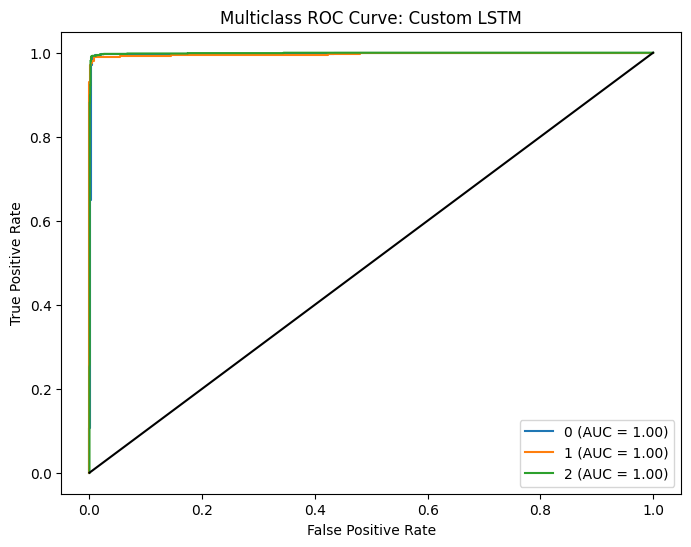

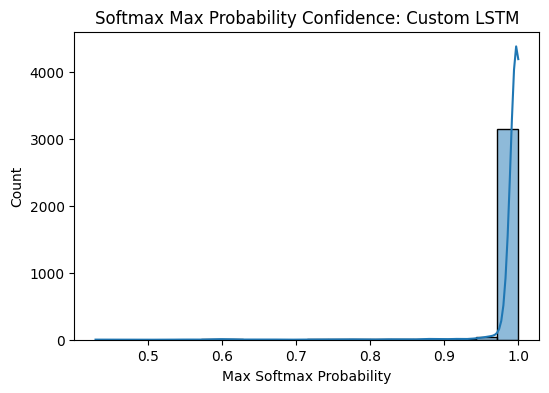


5 Good Predictions: 
True: 2, Predicted: 2, Confidence: 1.00, 
Text: spicer gives "alternative facts". wh press secretary sean spicer blasts media’s ‘deliberately false reporting’. breitbart news. ['white house', 'politics']. white house press secretary sean spicer held an emergency press briefing on saturday where he lit into the media for their “egregious” and “deliberately false reporting” of friday’s inauguration of president donald trump and his first day in office.


True: 1, Predicted: 1, Confidence: 1.00, 
Text: former trump organization cfo pleads guilty to tax fraud. trump organization: allen weisselberg pleads guilty to tax crimes. bbc news. ['justice', 'tax fraud', 'taxes', 'fraud', 'crime', 'trump organization', 'allen weisselberg']. the long-time financial chief of donald trump's company has pleaded guilty to fraud and tax evasion charges at a new york court.
allen weisselberg, who served as the trump organization's chief financial officer, had been charged with conceali

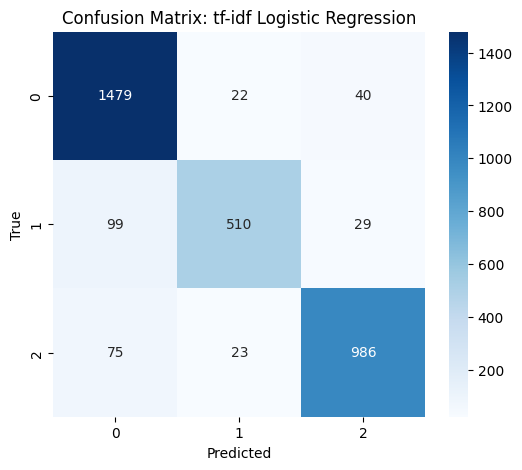

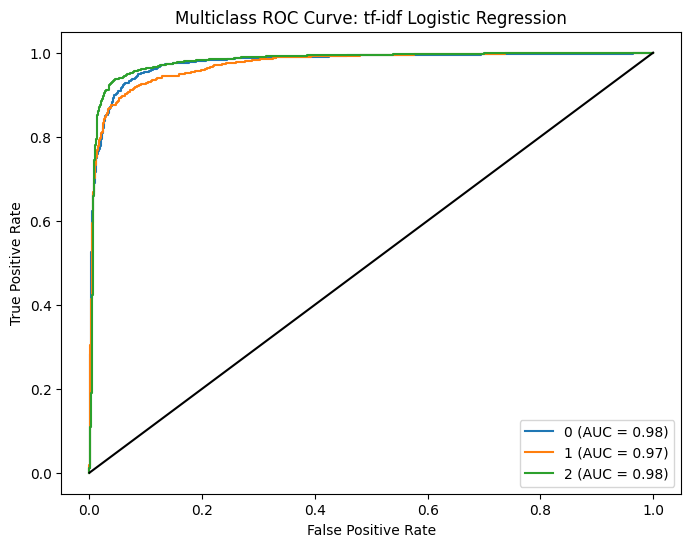

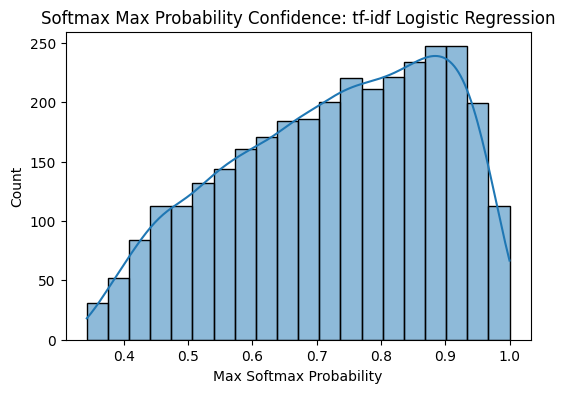


5 Good Predictions: 
True: 2, Predicted: 2, Confidence: 0.68, 
Text: spicer gives "alternative facts". wh press secretary sean spicer blasts media’s ‘deliberately false reporting’. breitbart news. ['white house', 'politics']. white house press secretary sean spicer held an emergency press briefing on saturday where he lit into the media for their “egregious” and “deliberately false reporting” of friday’s inauguration of president donald trump and his first day in office.


True: 1, Predicted: 1, Confidence: 0.74, 
Text: former trump organization cfo pleads guilty to tax fraud. trump organization: allen weisselberg pleads guilty to tax crimes. bbc news. ['justice', 'tax fraud', 'taxes', 'fraud', 'crime', 'trump organization', 'allen weisselberg']. the long-time financial chief of donald trump's company has pleaded guilty to fraud and tax evasion charges at a new york court.
allen weisselberg, who served as the trump organization's chief financial officer, had been charged with conceali

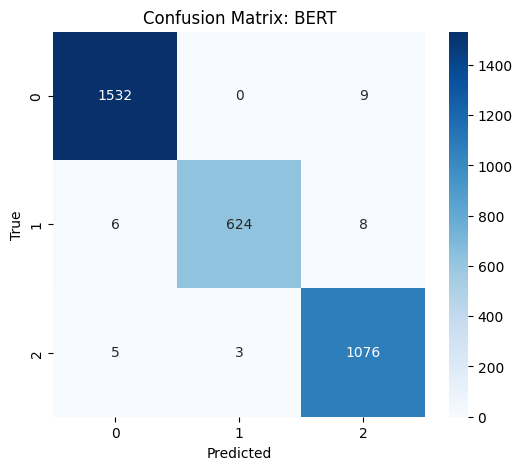

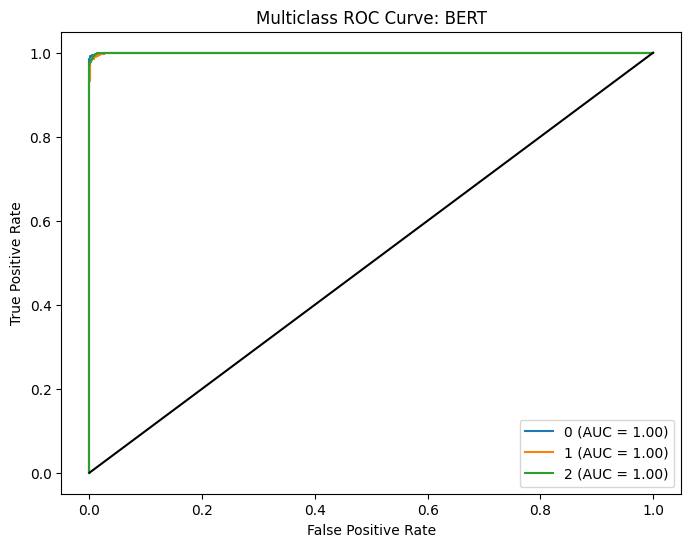

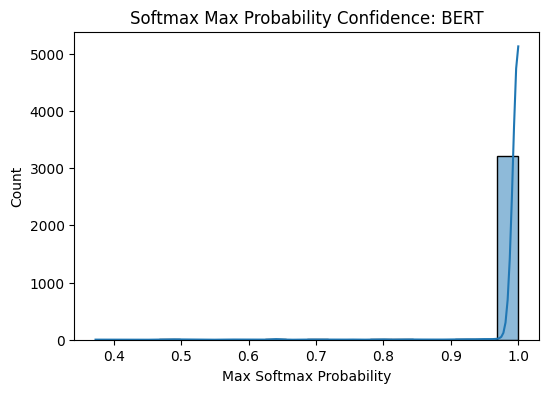


5 Good Predictions: 
True: 2, Predicted: 2, Confidence: 1.00, 
Text: spicer gives "alternative facts". wh press secretary sean spicer blasts media’s ‘deliberately false reporting’. breitbart news. ['white house', 'politics']. white house press secretary sean spicer held an emergency press briefing on saturday where he lit into the media for their “egregious” and “deliberately false reporting” of friday’s inauguration of president donald trump and his first day in office.


True: 1, Predicted: 1, Confidence: 1.00, 
Text: former trump organization cfo pleads guilty to tax fraud. trump organization: allen weisselberg pleads guilty to tax crimes. bbc news. ['justice', 'tax fraud', 'taxes', 'fraud', 'crime', 'trump organization', 'allen weisselberg']. the long-time financial chief of donald trump's company has pleaded guilty to fraud and tax evasion charges at a new york court.
allen weisselberg, who served as the trump organization's chief financial officer, had been charged with conceali

In [ ]:
# Run evaluation on all models
evaluate_model(LSTM_model, X_test, X_test_tokenized, y_test, "Custom LSTM")
evaluate_model(tf_idf_model, X_test, None, y_test, "tf-idf Logistic Regression")
evaluate_model(BERT_model, X_test, None, y_test, "BERT")

Now, get rationales from tf-idf + Logistic Regression

In [ ]:
# inverse map from id -> string label
id2label = {v: k for k, v in label_mapping.items()}

tfidf = tf_idf_model.named_steps["tfidfvectorizer"]
logreg = tf_idf_model.named_steps["logisticregression"]
feature_names = np.array(tfidf.get_feature_names_out())

def get_tf_idf_rationale_for_one(text, model, top_k=10):
    """
    text: single news article string (combined many parts here)
    model: our tf_idf_model
    top_k: number of top contributing tokens to show

    Returns:
      pred_label_id, pred_label_name, [(token, contribution_score), ...]
    """
    X_vec = tfidf.transform([text])  # shape: (1, vocab_size)

    probs = logreg.predict_proba(X_vec)[0]
    pred_label_id = int(np.argmax(probs))
    pred_label_name = id2label[pred_label_id]

    # Contributions = tf-idf value * class-specific coefficient
    coefs = logreg.coef_[pred_label_id]                # shape: (vocab_size,)
    contrib = X_vec.toarray().ravel() * coefs          # element-wise

    # Get top contributors
    top_idx = np.argsort(contrib)[-top_k:][::-1]
    tokens = feature_names[top_idx]
    scores = contrib[top_idx]

    rationale_tokens = [
        (tok, float(score)) for tok, score in zip(tokens, scores) if score > 0
    ]

    return pred_label_id, pred_label_name, rationale_tokens


# test
for i in range(3):
    text = X_test[i]
    true_id = int(y_test.iloc[i])
    true_label = id2label[true_id]

    pred_id, pred_label, rationale = get_tf_idf_rationale_for_one(
        text, tf_idf_model, top_k=10
    )

    print("="*80)
    print(f"Example {i}")
    print(f"True label: {true_label}  |  Predicted: {pred_label}")
    print("\nTop rationale tokens (tf-idf * weight):")
    for tok, score in rationale:
        print(f"  {tok:<20s}  {score:.4f}")
    print("\nText snippet:")
    print(text[:500], "...\n")

Example 0
True label: right  |  Predicted: right

Top rationale tokens (tf-idf * weight):
  breitbart news        0.5760
  breitbart             0.5258
  news                  0.1179
  media                 0.0886
  secretary             0.0860
  briefing              0.0842
  gives                 0.0762
  wh                    0.0695
  press secretary       0.0479
  press                 0.0458

Text snippet:
spicer gives "alternative facts". wh press secretary sean spicer blasts media’s ‘deliberately false reporting’. breitbart news. ['white house', 'politics']. white house press secretary sean spicer held an emergency press briefing on saturday where he lit into the media for their “egregious” and “deliberately false reporting” of friday’s inauguration of president donald trump and his first day in office. ...

Example 1
True label: center  |  Predicted: center

Top rationale tokens (tf-idf * weight):
  bbc news              0.5471
  bbc                   0.5191
  fraud            

**Phase 2**

First, we will get rationales. Then, build help-datasets. Then, we will use **teacher-student distillation setup** to supervise a smaller (cheaper and faster) student to perform better under heavier (expensive and slower) teacher model

In [ ]:
import pandas as pd
import numpy as np

def opposite_bias(label: str) -> str:
    if label == "left":
        return "right"
    if label == "right":
        return "left"
    return "balanced"   # for center

def build_phase2_df(X_split, y_split, max_examples=None):
    rows = []
    n = len(X_split) if max_examples is None else min(max_examples, len(X_split))

    for i in range(n):
        article = X_split[i]
        true_id = int(y_split.iloc[i])
        true_label = id2label[true_id]

        # tf-idf rationales
        _, pred_label, rationale = get_tf_idf_rationale_for_one(
            article, tf_idf_model, top_k=10
        )
        rationale_phrases = [tok for tok, score in rationale]
        rationale_str = ", ".join(rationale_phrases) if rationale_phrases else ""

        target_stance = opposite_bias(pred_label)

        rows.append(
            {
                "article": article,
                "true_label": true_label,
                "pred_bias": pred_label,
                "target_stance": target_stance,
                "rationales": rationale_str,
            }
        )

    return pd.DataFrame(rows)

phase2_train_df = build_phase2_df(X_train, y_train, max_examples=None)
phase2_test_df  = build_phase2_df(X_test,  y_test,  max_examples=None)

print(phase2_train_df.head())

                                             article true_label pred_bias  \
0  perspectives: the doj's dismissal of michael f...     center      left   
1  president trump backs out of g7 agreement. tru...      right     right   
2  trump defends mcmaster. trump backs mcmaster a...      right     right   
3  calls for schools to reopen grow as studies fi...      right     right   
4  ukraine rejects russia's request for surrender...       left      left   

  target_stance                                         rationales  
0         right  did, justice department, issue, president bara...  
1          left  washington examiner, examiner, washington, pre...  
2          left  news online, fox news, fox, online news, natio...  
3          left  washington, study, free, children, just, unive...  
4         right  washington post, post, mariupol, try, threaten...  


In [ ]:
!pip install transformers accelerate sentencepiece --quiet

In [ ]:
# !pip install -q google-generativeai

In [ ]:
# import google.generativeai as genai
# import os

# genai.configure(ENVIRONMENT "sandesh_key") #api as colab secret

# TEACHER_MODEL = "gemini-2.5-flash"  # good enough as a teacher (or pro)

In [ ]:
# Strict prompt builder (UPDATED for better flip-rate)

def build_prompt(row):
    STANCE_ANCHORS = {
        "left": "Emphasize social equity, protecting democratic institutions, corporate accountability, and inclusive public policy.",
        "right": "Emphasize limited government, fiscal responsibility, national security, individual freedom, and law and order."
    }

    # Fallback base case
    target_stance = str(row.get("target_stance", "")).strip().lower()
    if target_stance not in STANCE_ANCHORS:
        target_stance = str(row.get("target_stance", "")).strip()  # keep original for display
        # default anchor if unknown
        anchor = "Adopt the requested stance clearly and directly rebut the article’s framing."
    else:
        anchor = STANCE_ANCHORS[target_stance]

    return f"""
You are a political opinion writer.

TASK:
Write a clear and persuasive {row['target_stance']}-leaning counter-argument to the article below.

STANCE REQUIREMENTS:
- You MUST strongly adopt a {row['target_stance']}-leaning position.
- You MUST explicitly disagree with the article’s framing.
- Do NOT hedge or stay neutral.

CONTENT RULES:
- Write 2–4 sentences only.
- No repetition.
- Do NOT copy phrases or sentences from the original article.
- Focus on argumentation, not summary.

CONTEXT:
Original article bias: {row['pred_bias']}
Key biased phrases to challenge: {row['rationales']}

STANCE GUIDANCE:
{anchor}

ORIGINAL ARTICLE:
{row['article']}

Now write the {row['target_stance']}-leaning counter-argument:
""".strip()


# Build prompts for train/test Phase 2 sets
phase2_train_df["prompt"] = phase2_train_df.apply(build_prompt, axis=1)
phase2_test_df["prompt"] = phase2_test_df.apply(build_prompt, axis=1)

# sanity check
print("Example Phase-2 prompt:\n")
print(phase2_test_df["prompt"].iloc[0][:1200])


Example Phase-2 prompt:

You are a political opinion writer.

TASK:
Write a clear and persuasive left-leaning counter-argument to the article below.

STANCE REQUIREMENTS:
- You MUST strongly adopt a left-leaning position.
- You MUST explicitly disagree with the article’s framing.
- Do NOT hedge or stay neutral.

CONTENT RULES:
- Write 2–4 sentences only.
- No repetition.
- Do NOT copy phrases or sentences from the original article.
- Focus on argumentation, not summary.

CONTEXT:
Original article bias: right
Key biased phrases to challenge: breitbart news, breitbart, news, media, secretary, briefing, gives, wh, press secretary, press

STANCE GUIDANCE:
Emphasize social equity, protecting democratic institutions, corporate accountability, and inclusive public policy.

ORIGINAL ARTICLE:
spicer gives "alternative facts". wh press secretary sean spicer blasts media’s ‘deliberately false reporting’. breitbart news. ['white house', 'politics']. white house press secretary sean spicer held an 

In [ ]:
# old prompt: performed weaker under flip_rate EVAL method

# def build_prompt(row):
#     return (
#         "You are a fact-focused news analyst. However, you can have biases as per your target stance \n\n"
#         f"Article bias (as detected): {row['pred_bias']}.\n"
#         f"Target stance for the counter-argument: {row['target_stance']}.\n"
#         f"Key biased phrases to challenge (but write a detailed counter-narrative article on the whole article): {row['rationales'] or 'None explicitly'}.\n\n"
#         f"Article:\n{row['article']}\n\n"
#         "Write a detailed, civil, and well-reasoned counter-argument from the "
#         f"{row['target_stance']} perspective. Directly respond to the biased phrases, "
#         "provide alternative interpretations, and emphasize evidence-based reasoning (some bias is good).\n\n"
#         "Counter-argument:"
#     )

# phase2_train_df["prompt"] = phase2_train_df.apply(build_prompt, axis=1)
# phase2_test_df["prompt"]  = phase2_test_df.apply(build_prompt, axis=1)

In [ ]:
print(phase2_train_df.columns)
phase2_train_df[["article", "pred_bias", "target_stance", "rationales", "prompt"]].head(1)

Index(['article', 'true_label', 'pred_bias', 'target_stance', 'rationales',
       'prompt'],
      dtype='object')


,article,pred_bias,target_stance,rationales,prompt
0,perspectives: the doj's dismissal of michael f...,left,right,"did, justice department, issue, president bara...",You are a political opinion writer.\n\nTASK:\n...


In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# Student is flan-t5-base; teacher, a bigger model on the same GPU
TEACHER_MODEL_NAME = "google/flan-t5-large"  # or "google/flan-t5-xl"

teacher_tokenizer = AutoTokenizer.from_pretrained(TEACHER_MODEL_NAME)
teacher_model = AutoModelForSeq2SeqLM.from_pretrained(TEACHER_MODEL_NAME)
teacher_model.to(device)
teacher_model.eval()

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=1024, out_features=2816, bias=False)
              (wi_1): Linear(in_features=1024, out_features=2816, bias=False)
       

In [ ]:
import torch
import time

def generate_counter_argument_teacher(row, max_tokens=120):

    prompt = row["prompt"]  # contains stance, rationales, article, instructions

    # Encode
    enc = teacher_tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=512,   # cap (increased from 256)
    ).to(device)

    with torch.no_grad():
      output_ids = teacher_model.generate(
          **enc,
          do_sample=True,
          temperature=0.7,
          top_p=0.9,
          max_new_tokens=120,
          repetition_penalty=1.2,
          no_repeat_ngram_size=4,
          num_beams=1,
          early_stopping=True,
      )

    text = teacher_tokenizer.decode(output_ids[0], skip_special_tokens=True).strip()

    return text

In [ ]:
import math

MAX_TRAIN_TEACHER = 200  # can change to larger later if time allows

teacher_targets = []

for idx, row in phase2_train_df.iloc[:MAX_TRAIN_TEACHER].iterrows():
    print(f"\n### [Teacher] Generating sample {idx}/{MAX_TRAIN_TEACHER}")

    ca = generate_counter_argument_teacher(
        row,
        max_tokens=120,
    )
    teacher_targets.append(ca)

    if idx % 20 == 0:
        print("-" * 80)
        print("PROMPT:")
        print(row["prompt"], "...\n")
        print("TEACHER COUNTER-ARGUMENT:")
        print(ca)
        print("-" * 80)

phase2_train_df = phase2_train_df.iloc[:MAX_TRAIN_TEACHER].copy()
phase2_train_df["teacher_counter_argument"] = teacher_targets

phase2_train_df[["prompt", "teacher_counter_argument"]].head(3)


### [Teacher] Generating sample 0/200
--------------------------------------------------------------------------------
PROMPT:
You are a political opinion writer.

TASK:
Write a clear and persuasive right-leaning counter-argument to the article below.

STANCE REQUIREMENTS:
- You MUST strongly adopt a right-leaning position.
- You MUST explicitly disagree with the article’s framing.
- Do NOT hedge or stay neutral.

CONTENT RULES:
- Write 2–4 sentences only.
- No repetition.
- Do NOT copy phrases or sentences from the original article.
- Focus on argumentation, not summary.

CONTEXT:
Original article bias: left
Key biased phrases to challenge: did, justice department, issue, president barack, barack obama, national security, barack, beginning, basic, security adviser

STANCE GUIDANCE:
Emphasize limited government, fiscal responsibility, national security, individual freedom, and law and order.

ORIGINAL ARTICLE:
perspectives: the doj's dismissal of michael flynn's case. if michael flynn

,prompt,teacher_counter_argument
0,You are a political opinion writer.\n\nTASK:\n...,the president obama administration has not bee...
1,You are a political opinion writer.\n\nTASK:\n...,This article does not adequately address the r...
2,You are a political opinion writer.\n\nTASK:\n...,"President trump is a democratic ally, and shou..."


In [ ]:
# Student is flan-t5-base; teacher can be a bigger model on the same GPU
gen_model_name = "google/flan-t5-base"

gen_tokenizer = AutoTokenizer.from_pretrained(gen_model_name)
gen_model = AutoModelForSeq2SeqLM.from_pretrained(gen_model_name)
gen_model.to(device)
gen_model.eval()

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo):

In [ ]:
from torch.utils.data import Dataset, DataLoader

class CounterArgDataset(Dataset):
    def __init__(self, df, tokenizer, max_input_len=512, max_target_len=120):
        self.prompts = df["prompt"].tolist()
        self.targets = df["teacher_counter_argument"].tolist()
        self.tokenizer = tokenizer
        self.max_input_len = max_input_len
        self.max_target_len = max_target_len

    def __len__(self):
        return len(self.prompts)

    def __getitem__(self, idx):
        src = self.prompts[idx]
        tgt = self.targets[idx]

        src_enc = self.tokenizer(
            src,
            truncation=True,
            padding="max_length",
            max_length=self.max_input_len,
            return_tensors="pt",
        )
        tgt_enc = self.tokenizer(
            tgt,
            truncation=True,
            padding="max_length",
            max_length=self.max_target_len,
            return_tensors="pt",
        )

        item = {
            "input_ids": src_enc["input_ids"].squeeze(0),
            "attention_mask": src_enc["attention_mask"].squeeze(0),
        }

        labels = tgt_enc["input_ids"].squeeze(0)
        labels[labels == gen_tokenizer.pad_token_id] = -100  # ignore pad tokens
        item["labels"] = labels

        return item

train_dataset = CounterArgDataset(phase2_train_df, gen_tokenizer)


In [ ]:
from torch.utils.data import Dataset, DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    pin_memory=True,
    num_workers=2
)

In [ ]:
gen_model.train()
optimizer = torch.optim.AdamW(gen_model.parameters(), lr=2e-5)

EPOCHS = 3     # A100 can handle more, but taking longer

for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0.0

    for step, batch in enumerate(train_loader):
        try:
            batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}

            outputs = gen_model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                labels=batch["labels"],
            )

            loss = outputs.loss

            if torch.isnan(loss):
              print(f"❌ NaN loss at epoch {epoch+1}, step {step+1}. Stopping.")
              raise RuntimeError("NaN loss encountered")

            loss.backward()

            # Gradient clipping helps prevent spikes
            torch.nn.utils.clip_grad_norm_(gen_model.parameters(), 1.0)

            optimizer.step()
            optimizer.zero_grad()

            total_loss += loss.item()

        except torch.cuda.OutOfMemoryError:
            print("OOM during training: clearing cache and skipping batch")
            torch.cuda.empty_cache()
            continue

        if (step + 1) % 100 == 0:
            print(f"Epoch {epoch+1} | Step {step+1}/{len(train_loader)} | Loss: {loss.item():.4f}")
            torch.cuda.empty_cache()

    avg_loss = total_loss / len(train_loader)
    epoch_time = time.time() - start
    print(f"Epoch {epoch+1} completed. Avg Loss: {avg_loss:.4f} | Time: {epoch_time:.1f}s")

gen_model.eval()


Epoch 1 | Step 100/100 | Loss: 2.0551
🎯 Epoch 1 completed. Avg Loss: 1.7156 | Time: 15.9s
Epoch 2 | Step 100/100 | Loss: 1.7026
🎯 Epoch 2 completed. Avg Loss: 1.5134 | Time: 16.0s
Epoch 3 | Step 100/100 | Loss: 1.7183
🎯 Epoch 3 completed. Avg Loss: 1.4152 | Time: 15.8s


T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo):

In [ ]:
def detect_bias_of_text(text):
    """
    Use Phase 1 classifier (tf_idf_model) to detect bias of a given text.
    Returns label in {'left','right','center'}.
    """
    _, pred_label, _ = get_tf_idf_rationale_for_one(text, tf_idf_model, top_k=10)
    return pred_label

In [ ]:
def generate_counter_argument_from_row(row, model, tokenizer, device, max_new_tokens=120, gen_kwargs=None):
    prompt = row["prompt"]
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=512,
    ).to(device)

    # defaults (old settings)
    kwargs = dict(
        max_new_tokens=max_new_tokens,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        num_beams=1,
        repetition_penalty=1.2,
        no_repeat_ngram_size=4,
        early_stopping=True,
    )
    if gen_kwargs:
        kwargs.update(gen_kwargs)

    with torch.no_grad():
        output_ids = model.generate(**inputs, **kwargs)

    return tokenizer.decode(output_ids[0], skip_special_tokens=True).strip()



In [ ]:
def is_bad(text):
    """
    Heuristic filter to remove low-quality generations.
    """
    t = text.strip()

    # Too short: usually weak or generic
    if len(t) < 40:
        return True

    # Repetition heuristic: too many repeated 4-grams is bad
    words = t.lower().split()
    if len(words) >= 40:
        grams = [" ".join(words[i:i+4]) for i in range(len(words) - 3)]
        if len(set(grams)) / max(1, len(grams)) < 0.6:
            return True

    return False


In [ ]:
def best_of_n_counter(row, model, tokenizer, device, bias_fn, n=10, max_new_tokens=120):
    """
    Generate N candidates and return the first one that flips to target_stance
    and passes quality checks. Falls back gracefully if none match.
    """
    target_stance = row["target_stance"]
    candidates = []

    for _ in range(n):
        ca = generate_counter_argument_from_row(
            row,
            model,
            tokenizer,
            device,
            max_new_tokens=max_new_tokens
        )

        # Skip bad / degenerate outputs
        if is_bad(ca):
            continue

        ca_bias = bias_fn(ca)
        candidates.append((ca, ca_bias))

        if ca_bias == target_stance:
            return ca, ca_bias, candidates

    # Fallback: return first non-bad candidate if available
    if candidates:
        return candidates[0][0], candidates[0][1], candidates

    # Final fallback: generate once
    ca = generate_counter_argument_from_row(
        row,
        model,
        tokenizer,
        device,
        max_new_tokens=max_new_tokens
    )
    return ca, bias_fn(ca), [(ca, bias_fn(ca))]

In [ ]:
import numpy as np

# Only consider left/right true labels (ignore center)
mask_lr = phase2_test_df["true_label"].isin(["left", "right"])
phase2_lr_test = phase2_test_df[mask_lr].copy()

N_EVAL = 300  # or len(phase2_lr_test) if we want all
phase2_lr_test = phase2_lr_test.iloc[:N_EVAL].copy()

flipped = 0
valid = 0

examples_to_show = 5
shown = 0

for idx, row in phase2_lr_test.iterrows():
    original_bias = row["pred_bias"]      # what Phase 1 saw in the article
    target_stance = row["target_stance"]  # opposite stance we asked for

    if original_bias not in ["left", "right"]:
        continue  # just in case

    # ounter-argument with fine-tuned T5
    ca, ca_bias, _ = best_of_n_counter(
    row,
    gen_model,
    gen_tokenizer,
    device,
    detect_bias_of_text,
    n=10,
    max_new_tokens=120
)

    # Skip empty or super short generations
    if len(ca.strip()) < 10:
        continue

    valid += 1
    if ca_bias == target_stance:
        flipped += 1

    # show examples
    if shown < examples_to_show:
        shown += 1
        print("=" * 100)
        print(f"Example {shown}")
        print(f"ARTICLE true_label: {row['true_label']} | pred_bias: {original_bias}")
        print(f"Target stance (for counter-arg): {target_stance}")
        print(f"Counter-argument predicted bias: {ca_bias}\n")
        print("--- ARTICLE SNIPPET ---")
        print(row["article"][:400], "...\n")
        print("--- GENERATED COUNTER-ARGUMENT ---")
        print(ca)
        print("\n")

flip_rate = flipped / valid if valid > 0 else 0.0
print(f"✅ Evaluated {valid} counter-arguments.")
print(f"Flipped correctly (bias == target_stance): {flipped} ({flip_rate*100:.1f}%)")

Example 1
ARTICLE true_label: right | pred_bias: right
Target stance (for counter-arg): left
Counter-argument predicted bias: left

--- ARTICLE SNIPPET ---
spicer gives "alternative facts". wh press secretary sean spicer blasts media’s ‘deliberately false reporting’. breitbart news. ['white house', 'politics']. white house press secretary sean spicer held an emergency press briefing on saturday where he lit into the media for their “egregious” and “deliberately false reporting” of friday’s inauguration of president donald trump and his first day in o ...

--- GENERATED COUNTER-ARGUMENT ---
saturday’s press briefing was a rebuke to the media for their egregious and “deliberately false reporting” of friday’s inauguration of president donald trump and his first day in office.


Example 2
ARTICLE true_label: right | pred_bias: right
Target stance (for counter-arg): left
Counter-argument predicted bias: left

--- ARTICLE SNIPPET ---
what to watch for: the 2020 presidential election. what to